#Project Name: Molecular Classification of Cancer by Gene Expression Monitoring
* Author: Nguyen Thi Thu Hang
* Dataset: Gene expression dataset (Golub et al.)



##About [Dataset](https://https://www.kaggle.com/datasets/crawford/gene-expression?select=data_set_ALL_AML_train.csv) 
This dataset comes from a proof-of-concept study published in 1999 by Golub et al. It showed how new cases of cancer could be classified by gene expression monitoring (via DNA microarray) and thereby provided a general approach for identifying new cancer classes and assigning tumors to known classes. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).

Golub et al "Molecular Classification of Cancer: Class Discovery and Class
Prediction by Gene Expression Monitoring"

There are two datasets containing the initial (training, 38 samples) and independent (test, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood. Intensity values have been re-scaled such that overall intensities for each chip are equivalent.


## Set Up

In [1]:
!git clone https://github.com/NT-ThuHang/Cancer-Classification-using-Gene-Expression
%cd Cancer-Classification-using-Gene-Expression

Cloning into 'Cancer-Classification-using-Gene-Expression'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.
/content/Cancer-Classification-using-Gene-Expression


##Import library

In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc

In [3]:
np.random.seed(42)

##Load Dataset

In [4]:
train_df = pd.read_csv("./Dataset/data_set_ALL_AML_train.csv")
test_df = pd.read_csv("./Dataset/data_set_ALL_AML_independent.csv")
patient_number = pd.read_csv("./Dataset/actual.csv")
patient_number.columns = ["index","cancer_type"]

In [5]:
print("Shape of train_df ", train_df.shape)
train_df.head()

Shape of train_df  (7129, 78)


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [6]:
print("Shape of test_df ", test_df.shape)
test_df.head()

Shape of test_df  (7129, 70)


,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [7]:
print("Shape of patient_number ", patient_number.shape)
patient_number.head()

Shape of patient_number  (72, 2)


,index,cancer_type
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [8]:
#Delete all of "call" columns and two columns ["Gene Description","Gene Accession Number"]
column_name = [col for col in train_df.columns if "call" not in col]
train_df = train_df[column_name]
train_df = train_df.drop(["Gene Description","Gene Accession Number"], axis=1)
#transpose matrix
train_df = train_df.T

#labeling
train_df = train_df.reset_index()
train_df["index"] = pd.to_numeric(train_df["index"])
train_df = train_df.sort_values("index")

train_df = pd.merge(train_df, patient_number, on="index", how = "inner")
train_df.loc[train_df.cancer_type == "ALL", "cancer_type"] = 0
train_df.loc[train_df.cancer_type == "AML", "cancer_type"] = 1
#shuffle row
train_df = train_df.sample(frac=1, random_state = 0).drop(["index"], axis=1)
print("Size of training data", train_df.shape)
train_df.head()

Size of training data (38, 7130)


,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,cancer_type
22,-74,-321,-11,-36,-317,-499,-138,-119,115,-17,...,1058,140,176,-22,617,336,9,243,36,0
29,-318,-192,-95,312,-139,-344,324,-237,105,167,...,737,63,472,33,737,227,-9,371,-31,1
16,-476,-213,-18,301,-403,-394,-42,-144,98,173,...,1215,127,255,50,1701,1109,61,526,-83,0
15,-117,-219,-50,257,-218,-402,228,-147,65,67,...,631,-26,455,-62,736,445,42,246,-43,0
11,-67,-93,84,25,-179,-323,-135,-127,-2,-66,...,224,60,194,-10,291,41,8,-2,-80,0


In [9]:
#Delete all of "call" columns and two columns ["Gene Description","Gene Accession Number"]
column_name = [col for col in test_df.columns if "call" not in col]
test_df = test_df[column_name]
test_df = test_df.drop(["Gene Description","Gene Accession Number"], axis=1)
#transpose matrix
test_df = test_df.T

#labeling
test_df = test_df.reset_index()
test_df.head()
test_df["index"] = pd.to_numeric(test_df["index"])
test_df = test_df.sort_values("index")

test_df = pd.merge(test_df, patient_number, on="index", how = "inner")
test_df.loc[test_df.cancer_type == "ALL", "cancer_type"] = 0
test_df.loc[test_df.cancer_type == "AML", "cancer_type"] = 1
#shuffle row
test_df = test_df.sample(frac=1, random_state = 0).drop(["index"], axis=1)
print("Size of testing data", test_df.shape)
test_df.head()


Size of testing data (34, 7130)


,0,1,2,3,4,5,6,7,8,9,...,7120,7121,7122,7123,7124,7125,7126,7127,7128,cancer_type
11,-118,-142,212,314,-401,-452,-336,-310,177,-131,...,690,-8,331,-62,882,264,73,315,7,1
20,-12,-172,12,172,-137,-205,358,-104,-25,147,...,922,53,302,-78,673,208,-68,226,78,0
25,-48,-531,-124,431,-496,-696,-1038,-441,235,157,...,1141,-121,197,-108,466,349,0,284,-73,1
17,-95,-118,59,270,-229,-383,172,-187,185,157,...,700,-61,381,-105,1068,412,-43,702,18,0
2,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,383,46,104,15,245,164,84,100,-18,0


##Exploratory data analysis (EDA)

###Check the balance of training dataset

In [10]:
train_df["cancer_type"].value_counts()

0    27
1    11
Name: cancer_type, dtype: int64

Text(0.5, 1.0, 'Class Distributions \n ( AML ||  ALL)')

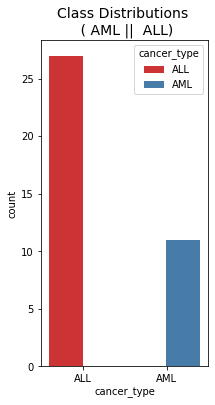

In [11]:
df = pd.DataFrame()
df["cancer_type"] = train_df["cancer_type"]
df.loc[df.cancer_type == 0, "cancer_type"] = "ALL"
df.loc[df.cancer_type == 1, "cancer_type"] = "AML"


plt.figure(figsize=(3,6))
colors = ["AML", "ALL"]
sns.countplot(x = 'cancer_type', hue = "cancer_type", data = df, palette = "Set1")
plt.title('Class Distributions \n ( AML ||  ALL)', fontsize=14)

###Distribution of the random sample before standardizing

In [12]:
sample = train_df.iloc[:,:-1].sample(n=100, axis=1)
sample.describe().round()

,7107,2177,927,4332,5312,5717,3968,5352,5546,2678,...,6878,233,2746,3477,3027,6209,5804,2929,2239,7008
count,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,...,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0
mean,-9.0,-13.0,1110.0,40.0,-451.0,-103.0,191.0,43.0,169.0,-31.0,...,269.0,646.0,-41.0,60.0,-176.0,11.0,14.0,-49.0,230.0,182.0
std,52.0,138.0,600.0,38.0,223.0,78.0,571.0,54.0,192.0,44.0,...,506.0,324.0,82.0,96.0,76.0,41.0,139.0,47.0,155.0,273.0
min,-114.0,-355.0,228.0,-25.0,-1022.0,-259.0,-320.0,-79.0,-47.0,-148.0,...,-471.0,211.0,-244.0,-121.0,-346.0,-47.0,-177.0,-115.0,13.0,-340.0
25%,-34.0,-74.0,641.0,16.0,-484.0,-165.0,-114.0,-2.0,60.0,-51.0,...,-71.0,408.0,-87.0,-19.0,-227.0,-17.0,-88.0,-67.0,110.0,-7.0
50%,-11.0,-22.0,1004.0,32.0,-394.0,-96.0,15.0,42.0,117.0,-36.0,...,128.0,591.0,-44.0,66.0,-177.0,2.0,-6.0,-54.0,182.0,135.0
75%,16.0,55.0,1399.0,69.0,-300.0,-44.0,285.0,80.0,190.0,-4.0,...,496.0,780.0,24.0,112.0,-130.0,33.0,90.0,-40.0,336.0,296.0
max,199.0,284.0,2535.0,148.0,-160.0,34.0,2124.0,212.0,850.0,45.0,...,1860.0,1605.0,117.0,287.0,-15.0,127.0,463.0,201.0,579.0,1182.0


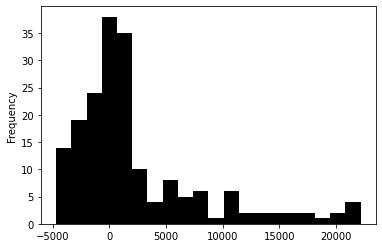

In [13]:
sample.plot(kind="hist", legend=None, bins=20, color='k')

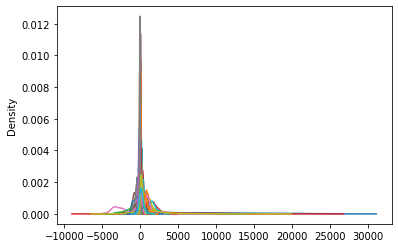

In [14]:
sample.plot(kind="kde", legend=None)

##Preprocessing 

In [15]:
X_train = train_df.iloc[:,:-1].reset_index(drop=True)
y_train = train_df.iloc[:,-1].reset_index(drop=True).astype("int")

X_test = test_df.iloc[:,:-1].reset_index(drop=True)
y_test = test_df.iloc[:,-1].reset_index(drop=True).astype("int")

In [16]:
X_train.shape

(38, 7129)

###StandardScaler

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)


###Distribution of the random sample after standardizing

In [18]:
sample = pd.DataFrame(X_train_scl).sample(n=100, axis=1)
sample.describe().round()

,4455,5449,1010,4,6761,5735,3819,7014,476,2344,...,3228,4344,6770,5037,2069,3503,4936,3796,2485,1880
count,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,...,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0
mean,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,-1.0,-3.0,-2.0,-3.0,-2.0,-2.0,-3.0,-1.0,-1.0,...,-1.0,-2.0,-2.0,-3.0,-3.0,-1.0,-2.0,-2.0,-2.0,-3.0
25%,-0.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-0.0,-1.0,...,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
75%,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,-0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
max,5.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,4.0,...,3.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0,3.0,1.0


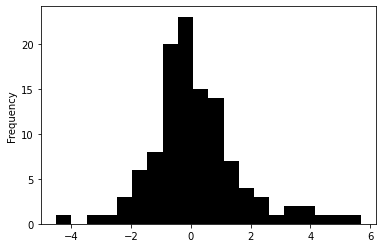

In [19]:
sample.plot(kind="hist", legend=None, bins=20, color='k')

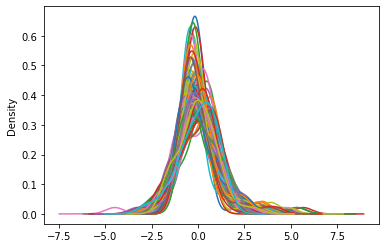

In [20]:
sample.plot(kind="kde", legend=None);

###PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train)

#calculate remaining dimentions
total = sum(pca.explained_variance_)
current_variance = 0
i = 0
while current_variance/total < 0.90:
  current_variance += pca.explained_variance_[i]
  i += 1
#PCA
pca = PCA(n_components = i)
X_train_pca = pca.fit_transform(X_train_scl)
X_test_pca = pca.fit_transform(X_test_scl)

In [22]:
X_train_pca.shape

(38, 22)

### Explore distribution of data through pca data 

[0.14987793 0.11977811 0.06600568]


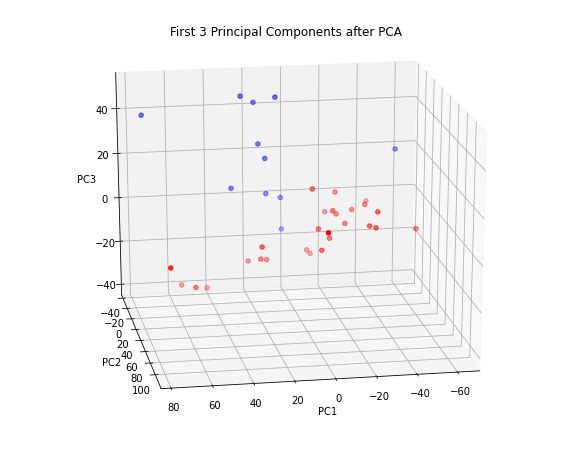

In [23]:
#Let's do a pca first 
pca = PCA(n_components=3)
pca.fit_transform(X_train_scl)
print(pca.explained_variance_ratio_) # Small variance explained

PCA_df = pd.DataFrame(data = pca.fit_transform(X_train_scl), 
                           columns = ['pc1', 'pc2', 'pc3'])

train_target= df.iloc[:,-1]
PCA_df = pd.concat([PCA_df, train_target], axis = 1)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
colors = {'ALL':'red', 'AML':'blue'}
ax.scatter(PCA_df.pc1, PCA_df.pc2, PCA_df.pc3, 
           c = train_target.apply(lambda x: colors[x]))
plt.title('First 3 Principal Components after PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(20, 80)
plt.tight_layout
plt.show()

##Classification

In [24]:
ROC_results = dict()
PR_results = dict()

###Using SVM Methods

In [25]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

#### Original

In [26]:
# Grid Search
# Parameter Grid
param_grid_SVM_non_pca = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [0.05,0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]} 
# Make grid search classifier
clf_grid_SVM_non_pca = GridSearchCV(svm.SVC(probability=True,random_state=0), param_grid_SVM_non_pca, cv=10, verbose=1)

# Train the classifier
clf_grid_SVM_non_pca.fit(X_train_scl, y_train)

# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid_SVM_non_pca.best_params_)
print("Best Estimators:\n", clf_grid_SVM_non_pca.best_estimator_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best Parameters:
 {'C': 0.05, 'gamma': 1, 'kernel': 'linear'}
Best Estimators:
 SVC(C=0.05, gamma=1, kernel='linear', probability=True, random_state=0)


In [27]:
model_svm_with_non_pca_data = svm.SVC(**clf_grid_SVM_non_pca.best_params_, probability=True, random_state=0)
model_svm_with_non_pca_data.fit(X_train_scl,y_train)
pred = model_svm_with_non_pca_data.predict(X_test_scl)
pred = pred.tolist()
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.7941176470588235


In [28]:
probas = model_svm_with_non_pca_data.predict_proba(X_test_scl)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["SVM"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["SVM"] = (precision, recall, AUCPR)

In [29]:
confusion_matrix(y_test, pred)

array([[20,  0],
       [ 7,  7]])

####PCA

In [30]:
# Grid Search
# Parameter Grid
param_grid_SVM_pca = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [0.05,0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10]} 
# Make grid search classifier
clf_grid_SVM_pca = GridSearchCV(svm.SVC(probability=True,random_state=0), param_grid_SVM_pca, refit=True, verbose=1)

# Train the classifier
clf_grid_SVM_pca.fit(X_train_pca, y_train)

# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid_SVM_pca.best_params_)
print("Best Estimators:\n", clf_grid_SVM_pca.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters:
 {'C': 0.05, 'gamma': 1, 'kernel': 'linear'}
Best Estimators:
 SVC(C=0.05, gamma=1, kernel='linear', probability=True, random_state=0)


In [31]:
model_svm_with_pca_data  = svm.SVC(**clf_grid_SVM_pca.best_params_, probability=True, random_state=0)
model_svm_with_pca_data .fit(X_train_pca,y_train)
pred = model_svm_with_pca_data .predict(X_test_pca)
pred = pred.tolist()
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.47058823529411764


In [32]:
probas = model_svm_with_pca_data.predict_proba(X_test_pca)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["SVM_PCA"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["SVM_PCA"] = (precision, recall, AUCPR)

In [33]:
confusion_matrix(y_test, pred)

array([[14,  6],
       [12,  2]])

###Using Kmeans Method

In [34]:
from sklearn.cluster import KMeans


####Original

In [35]:
model_KMeans_with_non_pca_data = KMeans(n_clusters=2, random_state=0)
model_KMeans_with_non_pca_data.fit_transform(X_train_scl)
pred = model_KMeans_with_non_pca_data.predict(X_test_scl)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.2647058823529412


In [36]:
confusion_matrix(y_test, pred)

array([[ 4, 16],
       [ 9,  5]])

####PCA

In [37]:
model_KMeans_with_pca_data = KMeans(n_clusters=2, random_state=0)
model_KMeans_with_pca_data.fit_transform(X_train_pca)
pred = model_KMeans_with_pca_data.predict(X_test_pca)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.7352941176470589


In [38]:
confusion_matrix(y_test, pred)

array([[16,  4],
       [ 5,  9]])

###Using Random Forest Method




In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 70, 80, 90, 100],
         'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
         'min_samples_leaf': [8, 10, 12, 14],
         'min_samples_split': [3, 5, 7]
        }


# Create the GridSearchCV object
model_Random_Forest_data = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=rf_param_grid, cv=3, scoring='accuracy')

# Fine-tune the hyperparameters
model_Random_Forest_data.fit(X_train, y_train)
print("Best Parameters:\n", model_Random_Forest_data.best_params_)
print("Best Estimators:\n", model_Random_Forest_data.best_estimator_)

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 70}
Best Estimators:
 RandomForestClassifier(bootstrap=False, max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=70, random_state=0)


In [41]:
# Get the best model
model_Radom_Forest_data_best = model_Random_Forest_data.best_estimator_

# Make predictions using the optimised parameters
pred = model_Radom_Forest_data_best.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.9117647058823529


In [42]:
probas = model_Radom_Forest_data_best.predict_proba(X_test_scl)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["Random_Forest"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["Random_Forest"] = (precision, recall, AUCPR)

In [43]:
confusion_matrix(y_test, pred)

array([[18,  2],
       [ 1, 13]])

###Using GradientBoostingClassifier

In [44]:
from sklearn.ensemble import GradientBoostingClassifier 

####Original

In [45]:
model_GradientBoostingClassifier_non_pca_data = GradientBoostingClassifier(max_depth=5, loss='exponential', n_estimators=50, learning_rate=0.8, random_state=0)
model_GradientBoostingClassifier_non_pca_data.fit(X_train_scl, y_train)
pred = model_GradientBoostingClassifier_non_pca_data.predict(X_test_scl)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.9117647058823529


In [46]:
probas = model_GradientBoostingClassifier_non_pca_data.predict_proba(X_test_scl)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["Gradient_Boosting_Classifier"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["Gradient_Boosting_Classifier"] = (precision, recall, AUCPR)

In [47]:
confusion_matrix(y_test, pred)

array([[18,  2],
       [ 1, 13]])

####PCA

In [48]:
model_GradientBoostingClassifier_pca_data= GradientBoostingClassifier(max_depth=5, loss='exponential', n_estimators=50, learning_rate=0.8, random_state=0)
model_GradientBoostingClassifier_pca_data.fit(X_train_pca, y_train)
pred = model_GradientBoostingClassifier_pca_data.predict(X_test_pca)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.5


In [49]:
probas = model_GradientBoostingClassifier_pca_data.predict_proba(X_test_pca)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["Gradient_Boosting_Classifier_PCA"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["Gradient_Boosting_Classifier_PCA"] = (precision, recall, AUCPR)

In [50]:
confusion_matrix(y_test, pred)

array([[13,  7],
       [10,  4]])

###Using XGBoost

In [51]:
import xgboost 

####Original

In [52]:
model_XGBoost_non_pca_data=xgboost.XGBClassifier(random_state=0)
model_XGBoost_non_pca_data.fit(X_train_scl, y_train)
pred = model_XGBoost_non_pca_data.predict(X_test_scl)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.9117647058823529


In [53]:
probas = model_XGBoost_non_pca_data.predict_proba(X_test_scl)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["XGBoost"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["XGBoost"] = (precision, recall, AUCPR)

In [54]:
confusion_matrix(y_test, pred)

array([[18,  2],
       [ 1, 13]])

####PCA


In [55]:
model_XGBoost_pca_data=xgboost.XGBClassifier(random_state=0)
model_XGBoost_pca_data.fit(X_train_pca, y_train)
pred = model_XGBoost_pca_data.predict(X_test_pca)
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.5


In [56]:
probas = model_XGBoost_pca_data.predict_proba(X_test_pca)[:,1]
y_test_ = np.asarray(test_df.iloc[:,-1].values, dtype="int")
#ROC and AUC
tpr, fpr, _ = roc_curve(y_test_, probas, pos_label=1)
ROCAUC = roc_auc_score(y_test_, probas)
ROC_results["XGBoost_PCA"] = (tpr, fpr, ROCAUC)

#PR
precision, recall, _ = precision_recall_curve(y_test_, probas, pos_label=1)
AUCPR = auc(recall, precision)
PR_results["XGBoost_PCA"] = (precision, recall, AUCPR)

In [57]:
confusion_matrix(y_test, pred)

array([[15,  5],
       [12,  2]])

###Using Neural Network

In [58]:
from tensorflow import keras

####Original

In [59]:
NN_model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=X_train_scl[1].shape),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [60]:
NN_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy']
)

In [61]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.005,
    restore_best_weights=True,
)

In [62]:
train_history = NN_model.fit(
    X_train_scl, y_train,
    validation_data=(X_test_scl, y_test),
    batch_size = 8,
    epochs = 500,
    callbacks=[early_stopping]
)

Epoch 1/500
5/5 [==============================] - 3s 45ms/step - loss: 1.6449 - binary_accuracy: 0.4737 - val_loss: 0.5896 - val_binary_accuracy: 0.7647
Epoch 2/500
5/5 [==============================] - 0s 13ms/step - loss: 0.1593 - binary_accuracy: 0.9211 - val_loss: 0.5473 - val_binary_accuracy: 0.7941
Epoch 3/500
5/5 [==============================] - 0s 10ms/step - loss: 0.0500 - binary_accuracy: 0.9737 - val_loss: 0.5407 - val_binary_accuracy: 0.7941
Epoch 4/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0279 - binary_accuracy: 1.0000 - val_loss: 0.5622 - val_binary_accuracy: 0.7647
Epoch 5/500
5/5 [==============================] - 0s 9ms/step - loss: 0.0170 - binary_accuracy: 1.0000 - val_loss: 0.5935 - val_binary_accuracy: 0.7353
Epoch 6/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0243 - binary_accuracy: 0.9737 - val_loss: 0.6208 - val_binary_accuracy: 0.7353
Epoch 7/500
5/5 [==============================] - 0s 9ms/step - loss: 0.0088

In [63]:
pred = np.asarray(NN_model.predict(X_test_scl)>0.5, dtype="int")
print('Accuracy: ', accuracy_score(y_test, pred))

Accuracy:  0.7941176470588235


In [64]:
confusion_matrix(y_test, pred)

array([[17,  3],
       [ 4, 10]])

#Graph Neural Network

I know with a small dataset like this it is overkill to use Graph Neural Network but i would like to implement it to test my idea and it might be useful for something in the future

###Set up

In [65]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-geometric

import torch_geometric
print(torch_geometric.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 27.6 MB/s 
     |████████████████████████████████| 3.5 MB 33.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 2.4 MB 22.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 709 kB 31.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 29.7 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=a887b476da5775d78e70f6a4b1cb20fb67824f9389643bb19440326325bc1db3
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e

In [101]:
import torch
import networkx as nx
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.logging import init_wandb, log

###Build Graph

In [67]:
def to_pyg(x, edge_head, edge_tail, y):
  data = Data(x = torch.tensor(x, dtype = torch.float),
              edge_index = torch.tensor([edge_head, edge_tail], dtype = int),
              y = torch.from_numpy(y))
  data.num_classes = len(torch.unique(data.y, return_counts=True))
  data.batch = 8
  return data

In [89]:
def graph_preparation(X_train, y_train, k):
  #node is sample
  #node feature consits of sample feature
  #edge is distance of sample, if sample_i in the set of k samples nearest with sample_j then i-j is an edge
  N = X_train.shape[0]
  distance = np.full((N,N), np.inf)
  #find distance matrix
  for i in range(N):
    for j in range(N):
      if (i==j):
        continue
      distance[i,j] = np.linalg.norm(X_train[i] - X_train[j])

  #find edge_head, edge_tail

  node_feature, edge_head, edge_tail = [], [], []

  for i in range(N):
    K_Nearest_Neighbors = np.argsort(distance[i,:])[:k]
    for neighbor in K_Nearest_Neighbors:
      edge_head += (i, neighbor)
      edge_tail += (neighbor, i) 
    #node features are the sample features
    node_feature.append(X_train[i,:])
  y_train = np.asarray(y_train, dtype="int")

  graph = to_pyg(node_feature, edge_head, edge_tail, y_train)
  return graph


In [93]:
train_graph = graph_preparation(X_train_scl, y_train, k=3).to(device)
test_graph = graph_preparation(X_test_scl, y_test, k=3).to(device)

In [134]:
def info_graph(graph):
  # Gather some statistics about the graph.
  print(f'Number of nodes: {graph.num_nodes}')
  print(f'Number of nodes: {graph.num_features}')
  print(f'Number of edges: {graph.num_edges}')
  print(f'Number of classes: {graph.num_classes}')
  print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
  print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
  print(f'Has self-loops: {graph.has_self_loops()}')
  print(f'Is undirected: {graph.is_undirected()}')
  

  g = torch_geometric.utils.to_networkx(graph, to_undirected=True)
  
  pos = nx.spring_layout(g)
  nx.draw(g, pos, node_size=100)

Number of nodes: 38
Number of nodes: 7129
Number of edges: 228
Number of classes: 2
Average node degree: 6.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


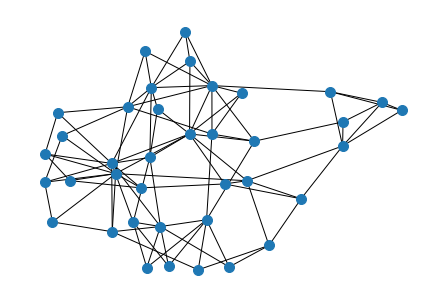

In [135]:
info_graph(train_graph)

Number of nodes: 34
Number of nodes: 7129
Number of edges: 204
Number of classes: 2
Average node degree: 6.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


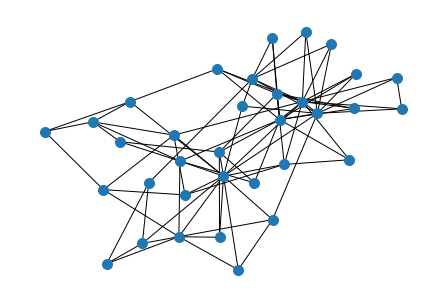

In [136]:
info_graph(test_graph)

###Construct Model

In [73]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(int(in_channels), int(hidden_channels))
        self.conv2 = GCNConv(int(hidden_channels), int(out_channels))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(in_channels = train_graph.num_features, hidden_channels = 16, out_channels=train_graph.num_classes)
print(model)

GCN(
  (conv1): GCNConv(7129, 16)
  (conv2): GCNConv(16, 2)
)


###Training and Testing

In [74]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(in_channels = train_graph.num_features, hidden_channels = 16, out_channels=train_graph.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
data = train_graph.to(device)


def train():
  model.train()
  total_loss = 0
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = F.cross_entropy(out, data.y)
  loss.backward()
  optimizer.step()
  total_loss += float(loss)/data.num_nodes
  return total_loss

@torch.no_grad()
def test(loader):
  model.eval()

  total_correct = 0
  pred = model(data.x, data.edge_index).argmax(dim=-1)
  total_correct += int((pred == data.y).sum())/data.num_nodes
  return total_correct 


for epoch in range(1, 50):
  loss = train()
  train_acc = test(train_graph)
  test_acc = test(test_graph)
  log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 0.0180, Train: 1.0000, Test: 1.0000
Epoch: 002, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 003, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 004, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 005, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 006, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 007, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 008, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 009, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 010, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 011, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 012, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 013, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 014, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 015, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 016, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 017, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 018, Loss: 0.0000, Train: 1.0000, Test: 1.0000
Epoch: 019, Loss: 0.0000, Tr

##Visualize Results

In [75]:
names = ['SVM',
         'SVM_PCA', 
         'Random_Forest', 
         'Gradient_Boosting_Classifier', 
         'Gradient_Boosting_Classifier_PCA', 
         'XGBoost',
         'XGBoost_PCA'
        ]

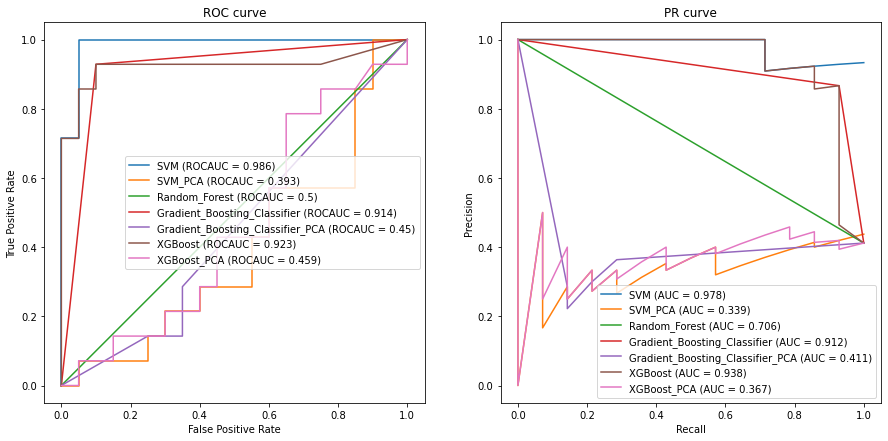

In [76]:
fig, (roc,pr) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15, 7))

#ROC
for clf in ROC_results.keys():
    roc.plot(ROC_results[clf][0], ROC_results[clf][1], label=f'{clf} (ROCAUC = {round(ROC_results[clf][2],3)})');

roc.set_xlabel('False Positive Rate')
roc.set_ylabel('True Positive Rate')
roc.set_title('ROC curve')
roc.legend();

#PR
for clf in PR_results.keys():
    pr.plot(PR_results[clf][1], PR_results[clf][0], label=f'{clf} (AUC = {round(PR_results[clf][2],3)})')

pr.set_xlabel('Recall')
pr.set_ylabel('Precision')
pr.set_title('PR curve')
pr.legend();
